In [1]:
import scanpy as sc
from anndata import read_h5ad
import pandas as pd
import numpy as np
import scipy as sp
from statsmodels.stats.multitest import multipletests
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import os
from os.path import join
import time
from gprofiler import GProfiler
import gseapy as gp

# scDRS tools
import scdrs.util as util
import scdrs.data_loader as dl
import scdrs.method as md

# autoreload
%load_ext autoreload
%autoreload 2

Set `DATA_PATH` to your local `scDRS_data_release_092121` folder

In [2]:
DATA_PATH = '/n/holystore01/LABS/price_lab/Users/mjzhang/scDRS_data_release_092121'

## Code to reproduce main results of the paper

In [3]:
# Set file paths
DF_HOM = pd.read_csv(DATA_PATH+'/gene_annotation/mouse_human_homologs.txt', sep='\t')
DIC_MAP_H2M = {x:y for x,y in zip(DF_HOM['HUMAN_GENE_SYM'], DF_HOM['MOUSE_GENE_SYM'])}
DIC_MAP_M2H = {x:y for x,y in zip(DF_HOM['MOUSE_GENE_SYM'], DF_HOM['HUMAN_GENE_SYM'])}
DF_GS = pd.read_csv(DATA_PATH+'/gs_file/magma_10kb_1000.74_traits.gs', sep='\t', index_col=0)
DF_TRAIT_INFO = pd.read_csv(DATA_PATH+'/supp_table/trait_info.tsv', sep='\t')
DF_TRAIT_INFO.index = DF_TRAIT_INFO['Trait_Identifier']
# FIG_PATH = '/n/holystore01/LABS/price_lab/Users/mjzhang/scDRS_data/results/fig_hep'

# Data set info
DS_LIST = ['facs']
DIC_INFO = {}
DIC_INFO['facs'] = {'species': 'mmusculus', 'dname': 'TMS FACS'}

# Set score files
# Include n_genes as cov only for atlas. Include individual ID as covariates when available
DIC_SCORE_PATH = {'facs': DATA_PATH+'/score_file/score.tms_facs_with_cov.magma_10kb_1000',
                  'facs.hm': DATA_PATH+'/score_file/score.tms_facs_with_cov.hep_metabolic'}

# Set trait list
DIC_TRAIT_LIST = {}
DIC_TRAIT_LIST['facs'] = ['UKB_460K.biochemistry_Triglycerides', 
                          'UKB_460K.biochemistry_HDLcholesterol',
                          'UKB_460K.biochemistry_LDLdirect',
                          'UKB_460K.biochemistry_Cholesterol',
                          'UKB_460K.biochemistry_Testosterone_Male',
                          'UKB_460K.biochemistry_AlanineAminotransferase',
                          'UKB_460K.biochemistry_AlkalinePhosphatase',
                          'UKB_460K.biochemistry_SHBG',
                          'UKB_460K.biochemistry_TotalBilirubin',
                          'UKB_460K.body_HEIGHTz']
DIC_TRAIT_LIST['facs.hm'] = ['CV', 'PN', 'hep4n_richter', 'hep2n_richter', 
                             'case_96hPH_vs_prePH', 'case_prePH_vs_96hPH', 
                             'case_vs_ctrl_96hPH', 'ctrl_vs_case_96hPH', 'large_vs_small',
                             'Glycolysis', 'Bile acid production', 'Lipogenesis', 'Xenobiotic metabolism',
                             'Beta-oxidation', 'Cholesterol biosynthesis', 'Protein secretion', 'Gluconeogenesis', 
                             ]

# Set trait info
DIC_HM_NAME = {'CV': 'pericentral',
               'PN': 'periportal',
               'hep4n_richter': '4n hepatocyte (vs. 2n)',
               'hep2n_richter': '2n hepatocyte (vs. 4n)',
               'case_96hPH_vs_prePH': 'polyploid (PH)',
               'case_prePH_vs_96hPH': 'diploid (PH)',
               'case_vs_ctrl_96hPH': 'polyploid (Cdk1 ko)',
               'ctrl_vs_case_96hPH': 'diploid (Cdk1 ko)',
               'large_vs_small': 'large hepatocyte (vs. small)',
               'Beta-oxidation': 'beta-oxidation (PN)',
               'Cholesterol biosynthesis': 'cholesterol biosynthesis (PN)', 
               'Glycolysis': 'glycolysis (CV)', 
               'Protein secretion': 'protein secretion (PN)',
               'Bile acid production': 'bile acid production (CV)', 
               'Gluconeogenesis': 'gluconeogenesis (PN)', 
               'Lipogenesis': 'lipogenesis (CV)', 
               'Xenobiotic metabolism': 'xenobiotic metabolism (CV)'}

for trait in DIC_HM_NAME:
    DF_TRAIT_INFO.loc[trait, 'Code'] = DIC_HM_NAME[trait]

### Load data 

In [4]:
# Load single-cell data 
dic_data_raw = {}
dic_data_raw['facs'] = dl.load_tms_ct(DATA_PATH, data_name='facs')

dic_data_proc = {}
dic_data_proc['facs'] = read_h5ad(DATA_PATH+'/single_cell_data/tms_proc/hep.facs_annot.h5ad')

Trying to set attribute `.obs` of view, copying.


In [5]:
# Load score 
dic_score = {x:pd.DataFrame() for x in DIC_SCORE_PATH}
for score in DIC_SCORE_PATH:
    for trait in DIC_TRAIT_LIST[score]:
        file_path = join(DIC_SCORE_PATH[score], '%s.score.gz'%trait)
        if os.path.exists(file_path):
            temp_df = pd.read_csv(file_path, sep='\t', index_col=0)
            temp_df.columns = ['%s.%s'%(trait,x) for x in temp_df.columns]
            temp_df['%s.fdr'%trait] = multipletests(temp_df['%s.pval'%trait], method='fdr_bh')[1]
            dic_score[score] = pd.concat([dic_score[score], temp_df], axis=1)
        else:
            print('# missing: %s'%file_path)        

# Cell list to analyze
dic_cell_list = {}
for score in DIC_SCORE_PATH:
    ds = score.replace('.hm','')
    dic_cell_list[score] = list(set(dic_data_proc[ds].obs_names) & set(dic_score[score].index))

In [6]:
# Load control score 
dic_ctrl_score = {}
for score in DIC_SCORE_PATH:
# for score in ['aizarani', 'halpern', 'richter']:
    ds = score.split('.')[0]
    dic_ctrl_score[score] = {}
    for trait in DIC_TRAIT_LIST[score]:
        file_path = join(DIC_SCORE_PATH[score], '%s.full_score.gz'%trait)
        if os.path.exists(file_path):
            print('# Loading %s %s'%(score, trait))
            temp_df = pd.read_csv(file_path, sep='\t', index_col=0)
            temp_df = temp_df.loc[set(dic_data_proc[ds].obs_names) & set(temp_df.index)]
            dic_ctrl_score[score][trait] = temp_df.copy()
        else:
            print('# missing: %s'%file_path)
            continue
        dic_ctrl_score[score][trait] = dic_ctrl_score[score][trait].loc[dic_cell_list[score]].copy()

# Loading facs UKB_460K.biochemistry_Triglycerides
# Loading facs UKB_460K.biochemistry_HDLcholesterol
# Loading facs UKB_460K.biochemistry_LDLdirect
# Loading facs UKB_460K.biochemistry_Cholesterol
# Loading facs UKB_460K.biochemistry_Testosterone_Male
# Loading facs UKB_460K.biochemistry_AlanineAminotransferase
# Loading facs UKB_460K.biochemistry_AlkalinePhosphatase
# Loading facs UKB_460K.biochemistry_SHBG
# Loading facs UKB_460K.biochemistry_TotalBilirubin
# Loading facs UKB_460K.body_HEIGHTz
# Loading facs.hm CV
# Loading facs.hm PN
# Loading facs.hm hep4n_richter
# Loading facs.hm hep2n_richter
# Loading facs.hm case_96hPH_vs_prePH
# Loading facs.hm case_prePH_vs_96hPH
# Loading facs.hm case_vs_ctrl_96hPH
# Loading facs.hm ctrl_vs_case_96hPH
# Loading facs.hm large_vs_small
# Loading facs.hm Glycolysis
# Loading facs.hm Bile acid production
# Loading facs.hm Lipogenesis
# Loading facs.hm Xenobiotic metabolism
# Loading facs.hm Beta-oxidation
# Loading facs.hm Cholesterol biosynt

### Annotation for TG associated cells 

... storing 'tissue_celltype' as categorical
... storing 'leiden_sig' as categorical


# Removed: Hsl
# Removed: Dgat


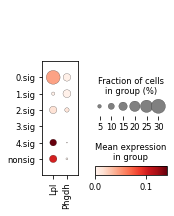

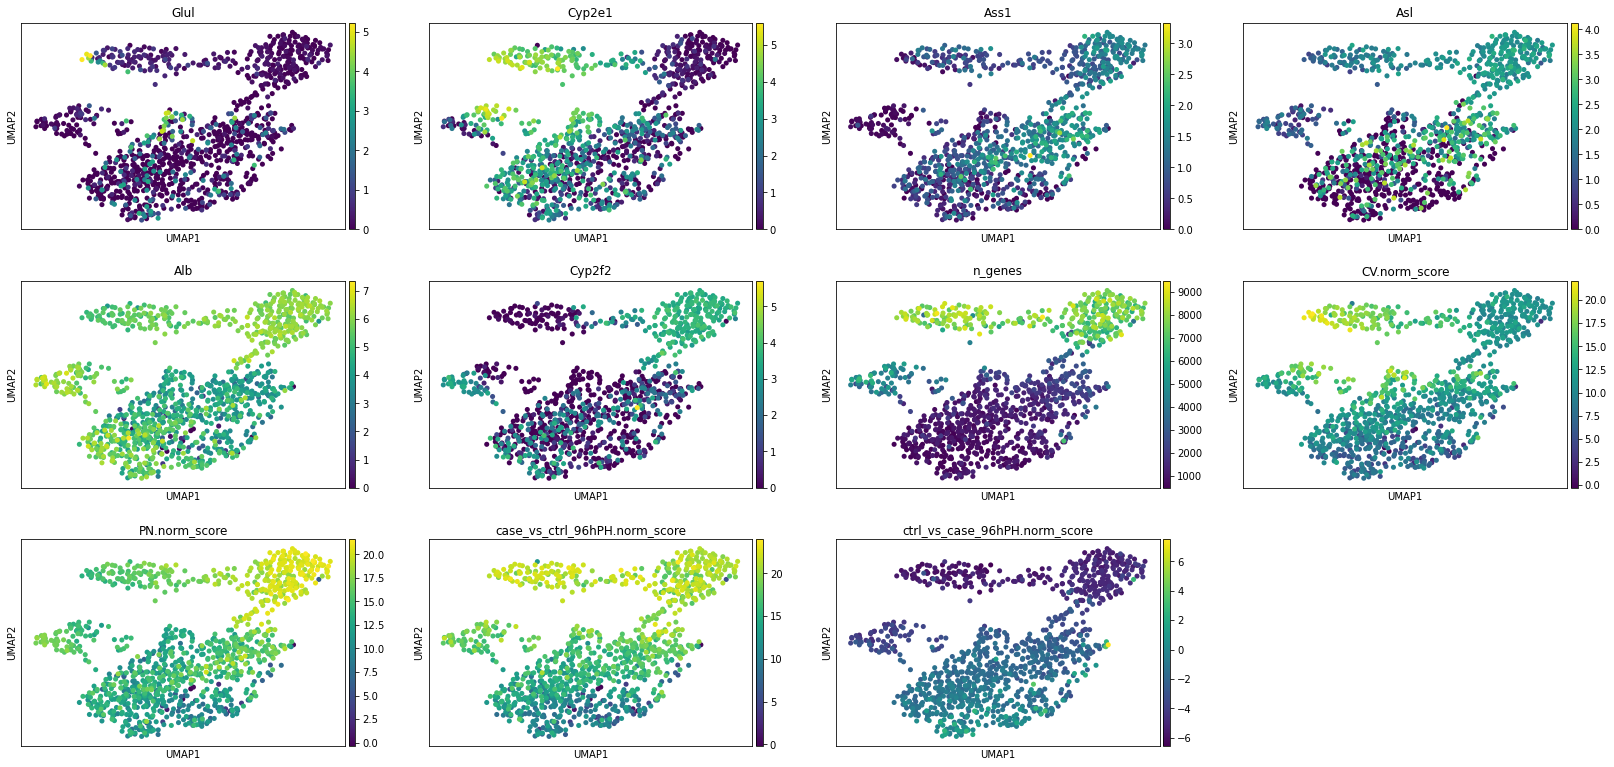

In [7]:
# trait = 'UKB_460K.biochemistry_LDLdirect'
trait = 'UKB_460K.biochemistry_Triglycerides'
ds = 'facs'

# Assign sig label for each leiden cluster (remove sig cells in small clusters)
adata = dic_data_raw[ds][dic_cell_list[ds], :].copy()
temp_adata = dic_data_proc[ds][dic_cell_list[ds], :].copy()
adata.obs = adata.obs.join(temp_adata.obs[[x for x in temp_adata.obs.columns if x not in adata.obs.columns]])
adata.obsm = temp_adata.obsm

adata.obs = adata.obs.join(dic_score[ds]['%s.fdr'%trait])
adata.obs['leiden_sig'] = ['%s.sig'%x if y<0.1 else 'nonsig'
                           for x,y in zip(adata.obs['leiden'], adata.obs['%s.fdr'%trait])]

temp_df = adata.obs.groupby(['leiden_sig']).agg({'cell':len})
cluster_remove_list = list(temp_df.index[temp_df['cell']<25])
adata.obs.loc[adata.obs['leiden_sig'].isin(cluster_remove_list), 'leiden_sig'] = 'nonsig' 

# Specifically expressed genes 
group_list = sorted([x for x in adata.obs['leiden_sig'].unique() if '.sig' in x])
# sc.tl.rank_genes_groups(adata, groupby='leiden_sig', reference='rest', groups=group_list+['nonsig'])
# sc.pl.rank_genes_groups(adata, fontsize=10, ncols=2, n_genes=25)

# Marker gene expression 
marker_list = ['Lpl', 'Hsl', 'Dgat', 'Phgdh', # TG regulation
#                'Vldlr', 'Ldlr', 'Lrp1', 'Scarb1', 'Srebf2', 'Scap', 'Pcsk9', 'Sar1b', 'Itgav', 
#                'Adipoq', 'App', 'Itgb3', 'Psen1', 'Hnrnpk', 'Anxa2', 'Pparg', 'Cnpy2', # Lipoprotein receptor
#                'Alb', # Plasma protein secretion
#                'Fgb', 'F2', 'F9', 'Kng1', 'Aplp2', # Blood clotting factors 
#                'Gc', # Vitamin D
#                'G6pc', # Glycogenolysis and gluconeogenesis
#                'Cyp', 'Glul', 'Oat', 'Ces3a', 'Slc22a1', 'Aldh3a2', # Detoxification
#                'Akr1c6', 'Abcb4', # Bile acid synthesis
#                'Blvrb', # Heme synthesis
#                'Csad', # Amino acid metabolism
#                'Rgn', # Calcium homeostasis
#                'Hmgcl', # Ketogenesis
#                'Stard10', 'Apoa', 'Apoc', # Hormone, vitamin, and lipid transport
#                'Hmgcs2', 'Aldh2', 'Ppara', 'MGll', # Cholesterol, alcohol and lipid metabolism
#                'Agt', 'Igfbp2', 'Igfbp4', # Hormone synthesis and secretion
#                'Hamp', 'Ftl1', 'Hp', # Iron homeostasis and storage
#                'Ass1', 'Asl', # Urea synthesis from ammonia 
#                'Gpx1', # Glutathione synthesis 
#                'Pck1', 'Fbp1', # Gluconeogenesis
#                'Arg1', # Urea synthesis from arginine
#                'Cat', # Catalase production
#                'Cox', 'Nduf' # Respiration (b-oxidation)
#                'Glul', 'Apoe', 'Cyp1a2', 'Cyp2e1', 'Cyp2f2', 'Cyp2e1', # Central
#                'Arg1', 'Alb', 'Pck1' # Periportal
              ]
for gene in marker_list.copy():
    if gene not in adata.var_names:
        marker_list.remove(gene)
        print('# Removed: %s'%gene)
sc.pl.dotplot(adata, marker_list, groupby='leiden_sig')

# Zonation markers
marker_list = ['Glul', 'Cyp2e1', 'Ass1', 'Asl', 'Alb', 'Cyp2f2',
               'n_genes', 'CV.norm_score', 'PN.norm_score',
               'case_vs_ctrl_96hPH.norm_score', 'ctrl_vs_case_96hPH.norm_score']
adata.obs = adata.obs.join(dic_score['facs.hm'][['CV.norm_score', 'PN.norm_score',
                                                 'case_vs_ctrl_96hPH.norm_score', 'ctrl_vs_case_96hPH.norm_score']])
sc.pl.umap(adata, color=marker_list)

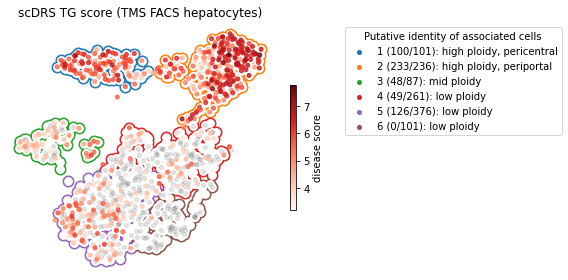

In [8]:
# UMAP plot with annotations 
ds='facs'
group_list = sorted([x for x in adata.obs['leiden_sig'].unique() if '.sig' in x])
dic_config = {'0': ['C0', '1 @a: high ploidy, pericentral'],
              '1': ['C1', '2 @a: high ploidy, periportal'],
              '2': ['C2', '3 @a: mid ploidy'], 
              '3': ['C3', '4 @a: low ploidy'], 
              '4': ['C4', '5 @a: low ploidy'],
              '5': ['C5', '6 @a: low ploidy']
             }

# Get df_plot 
df_plot = pd.DataFrame(index=adata.obs_names,
                       data={'UMAP1':adata.obsm['X_umap'][:,0],
                             'UMAP2':adata.obsm['X_umap'][:,1]})
df_plot = df_plot.join(adata.obs[['leiden', 'leiden_sig']])
df_plot = df_plot.loc[dic_cell_list[ds]]
df_plot = df_plot.join(dic_score[ds][['%s.fdr'%trait, '%s.nlog10_pval'%trait, '%s.norm_score'%trait]])
df_plot.sort_values('%s.fdr'%trait, ascending=False, inplace=True)

# Figure 
plt.figure(figsize=[8,4])
ax = plt.subplot(1,1,1)
ax.axis('off')

# Cluster boundry 
x_range = df_plot['UMAP1'].max()-df_plot['UMAP1'].min()
y_range = df_plot['UMAP2'].max()-df_plot['UMAP2'].min()
for cluster in dic_config:
    ind_select = df_plot['leiden']==cluster
    n_sig,n_tot = (df_plot['leiden_sig']=='%s.sig'%cluster).sum(),ind_select.sum()
    temp_df = df_plot.loc[ind_select, ['UMAP1', 'UMAP2']].copy()
    xmin = np.quantile(temp_df['UMAP1'], 0.05)-0.05*x_range,
    xmax = np.quantile(temp_df['UMAP1'], 0.95)+0.05*x_range
    ymin = np.quantile(temp_df['UMAP2'], 0.05)-0.05*y_range,
    ymax = np.quantile(temp_df['UMAP2'], 0.95)+0.05*y_range
    ind_select = (temp_df['UMAP1']>xmin) & (temp_df['UMAP1']<xmax) & \
                    (temp_df['UMAP2']>ymin) & (temp_df['UMAP2']<ymax)
    plt.scatter(temp_df.loc[ind_select, 'UMAP1'][:2], temp_df.loc[ind_select, 'UMAP2'][:2],
                s=16, color=dic_config[cluster][0], 
                label=dic_config[cluster][1].replace('@a', '(%d/%d)'%(n_sig,n_tot)), 
                zorder=0)
    plt.scatter(temp_df.loc[ind_select, 'UMAP1'], temp_df.loc[ind_select, 'UMAP2'],
                s=120, color=dic_config[cluster][0], zorder=1)
    plt.scatter(temp_df.loc[ind_select, 'UMAP1'], temp_df.loc[ind_select, 'UMAP2'],
                s=60, color='w', zorder=2)

ind_select_sig = (df_plot['leiden_sig']!='nonsig')
np.random.seed(0)
cell_list_nonsig = np.random.choice(df_plot.index[~ind_select_sig], 
                                    size=int((~ind_select_sig).sum()*0.5), replace=False)
plt.scatter(df_plot.loc[cell_list_nonsig, 'UMAP1'], df_plot.loc[cell_list_nonsig, 'UMAP2'],
                c='k', s=16, alpha=0.1, zorder=5)

vmax = np.quantile(df_plot.loc[ind_select_sig, '%s.norm_score'%trait], 0.99) + 0.5
vmin = np.quantile(df_plot.loc[ind_select_sig, '%s.norm_score'%trait], 0.01) - 0.5
plt.scatter(df_plot.loc[ind_select_sig, 'UMAP1'], df_plot.loc[ind_select_sig, 'UMAP2'], 
            c=df_plot.loc[ind_select_sig, '%s.norm_score'%trait],
            cmap='Reds', s=16, vmax=vmax, vmin=vmin, alpha=0.8, zorder=10)
plt.colorbar(shrink=0.5, label='disease score')
plt.legend(bbox_to_anchor=(1.25, 1), loc='upper left', title='Putative identity of associated cells')
plt.title('scDRS %s score (TMS FACS hepatocytes)'%DF_TRAIT_INFO.loc[trait, 'Code'])
plt.tight_layout()
# plt.savefig(FIG_PATH+'/sctrs_assoc.annot_%s_umap.svg'%DF_TRAIT_INFO.loc[trait, 'Code'])
# plt.savefig(FIG_PATH+'/sctrs_assoc.annot_%s_umap.png'%DF_TRAIT_INFO.loc[trait, 'Code'])
plt.show()

### Joint regression analysis based on covariates 

In [10]:
# Consistency of ploidy score 
n_ctrl = 1000
ploidy_term = 'case_96hPH_vs_prePH'
ploidy_term_list = ['hep4n_richter', 'case_vs_ctrl_96hPH', 'large_vs_small',
                    'hep2n_richter', 'ctrl_vs_case_96hPH', 'case_prePH_vs_96hPH']
ds_list = DS_LIST
df_stats_ploidy = pd.DataFrame(index=ploidy_term_list, columns=ds_list, dtype=float)
df_stats_ploidy_corr = pd.DataFrame(index=ploidy_term_list, columns=ds_list, dtype=float)

for ds in ds_list:
    for term in ploidy_term_list:
        df_reg = dic_score['%s.hm'%ds].loc[dic_cell_list[ds], 
                                           ['%s.norm_score'%ploidy_term, '%s.norm_score'%term]].copy()
        df_reg = df_reg.join(dic_ctrl_score['%s.hm'%ds][term])

        corr_ = np.corrcoef(df_reg['%s.norm_score'%ploidy_term], df_reg['%s.norm_score'%term])[0,1]
        v_corr_ = np.zeros(n_ctrl) 
        for i in range(n_ctrl):
            v_corr_[i] = np.corrcoef(df_reg['%s.norm_score'%ploidy_term], df_reg['ctrl_norm_score_%d'%i])[0,1]
        if term in ['hep4n_richter', 'case_96hPH_vs_prePH', 'case_vs_ctrl_96hPH', 'large_vs_small']:
            p_=((corr_ <= v_corr_).sum()+1) / (n_ctrl+1)
        else:
            p_=((corr_ >= v_corr_).sum()+1) / (n_ctrl+1)
        df_stats_ploidy.loc[term, ds] = p_
        df_stats_ploidy_corr.loc[term, ds] = corr_
display(df_stats_ploidy)
display(df_stats_ploidy_corr)

# Make table 
df_res = df_stats_ploidy.copy()
df_res.index = [DF_TRAIT_INFO.loc[x, 'Code'] for x in df_res.index]
df_res.columns = [DIC_INFO[x]['dname'].replace('&','\&') for x in df_res.columns]
for col in df_res.columns:
    df_res[col] = ['$\textbf{%0.3f}$'%x if x<0.005 else '$%0.3f$'%x for x in df_res[col]]
print(df_res.to_latex(index=True, escape=False, column_format='|c|cccccc|'))

,facs
hep4n_richter,0.000999
case_vs_ctrl_96hPH,0.000999
large_vs_small,0.000999
hep2n_richter,0.475524
ctrl_vs_case_96hPH,0.000999
case_prePH_vs_96hPH,0.000999


,facs
hep4n_richter,0.866177
case_vs_ctrl_96hPH,0.951898
large_vs_small,0.905383
hep2n_richter,-0.030829
ctrl_vs_case_96hPH,-0.828082
case_prePH_vs_96hPH,-0.844562


\begin{tabular}{|c|cccccc|}
\toprule
{} &          TMS FACS \\
\midrule
4n hepatocyte (vs. 2n)       &  $\textbf{0.001}$ \\
polyploid (Cdk1 ko)          &  $\textbf{0.001}$ \\
large hepatocyte (vs. small) &  $\textbf{0.001}$ \\
2n hepatocyte (vs. 4n)       &           $0.476$ \\
diploid (Cdk1 ko)            &  $\textbf{0.001}$ \\
diploid (PH)                 &  $\textbf{0.001}$ \\
\bottomrule
\end{tabular}



In [11]:
# Prepare regression datasets 
dic_cov = {}
ploidy_term = 'case_96hPH_vs_prePH'

# FACS all 
dic_cov['facs'] = dic_data_proc['facs'].obs.copy()
dic_cov['facs']['ploidy'] = dic_score['facs.hm'].loc[dic_cov['facs'].index, '%s.norm_score'%ploidy_term]
dic_cov['facs']['CV'] = dic_score['facs.hm'].loc[dic_cov['facs'].index, 'CV.norm_score']
dic_cov['facs']['PN'] = dic_score['facs.hm'].loc[dic_cov['facs'].index, 'PN.norm_score']

# Add const and leiden
for cov_name in dic_cov:
    dic_cov[cov_name]['const'] = 1
    for cluster in set(dic_cov[cov_name]['leiden']):
        dic_cov[cov_name]['leidenreg_%s'%cluster] = (dic_cov[cov_name]['leiden']==cluster)*1
    
# Regout ploidy from CV/PN
for cov_name in dic_cov:
    mat_Y = np.ones([dic_cov[cov_name].shape[0],2])
    mat_Y[:,1] = dic_cov[cov_name]['ploidy']
    dic_cov[cov_name]['CV'] = md.reg_out(dic_cov[cov_name]['CV'], mat_Y)
    dic_cov[cov_name]['PN'] = md.reg_out(dic_cov[cov_name]['PN'], mat_Y)
    print('%s CV-PN corr.=%0.3f'%(cov_name, np.corrcoef(dic_cov[cov_name]['CV'], dic_cov[cov_name]['PN'])[0,1]))


facs CV-PN corr.=-0.659


In [12]:
dic_reg = {'reg_joint': ['ploidy', 'CV', 'PN'], 
#            'reg_joint_cluster': ['ploidy', 'CV', 'PN']
          }
trait_black_list = ['CV', 'PN', ploidy_term]

dic_stats = {}
for cov_name in dic_cov:
    for reg_name in dic_reg:
        
        if reg_name.endswith('_cluster'):
            ctrl_list = ['const'] + [x for x in dic_cov[cov_name].columns if 'leidenreg' in x]
        else:
            ctrl_list = ['const']
        print(cov_name, reg_name, ','.join(ctrl_list))
        
        reg_list = dic_reg[reg_name]
        df_stats = pd.DataFrame(columns=['var_ctrl','var']+['%s.%s'%(y,x) for x in reg_list for y in ['T', 'P']])
        ds = cov_name.split('_' )[0]
        
        for score in [ds, ds+'.hm']:
            for trait in DIC_TRAIT_LIST[score]:
                if '%s.norm_score'%trait not in dic_score[score]:
                    continue
                if trait in trait_black_list:
                    continue                

                df_reg = dic_cov[cov_name][reg_list+ctrl_list].copy()
                df_reg = df_reg.join(dic_score[score][['%s.norm_score'%trait]])
                df_reg = df_reg.join(dic_ctrl_score[score][trait])
                
                res = sm.OLS(df_reg['%s.norm_score'%trait], df_reg[ctrl_list]).fit()
                var_explain_ctrl_ = 1 - res.mse_resid/res.mse_total

                res = sm.OLS(df_reg['%s.norm_score'%trait], df_reg[ctrl_list+reg_list]).fit()
                var_explain_ = 1 - res.mse_resid/res.mse_total
                dic_t = {x:res.tvalues[x] for x in reg_list}
                dic_t_ctrl = {x:np.zeros(n_ctrl) for x in reg_list}

                for i in range(n_ctrl):
                    res = sm.OLS(df_reg['ctrl_norm_score_%d'%i], df_reg[ctrl_list+reg_list]).fit()
                    for reg in reg_list:
                        dic_t_ctrl[reg][i] = res.tvalues[reg]

                dic_p = {x:((dic_t[x] <= dic_t_ctrl[x]).sum()+1) / (n_ctrl+1) for x in reg_list} 
                df_stats.loc[trait] = [var_explain_ctrl_, var_explain_] + \
                    [y[x] for x in reg_list for y in [dic_t, dic_p]]

        for reg_term in reg_list:
            df_stats['P_STR.%s'%reg_term] = [util.p_2_str(x) for x in df_stats['P.%s'%reg_term]]
            df_stats['P_STR_NUM.%s'%reg_term] = [util.p_2_str_num(x, n_ctrl) for x in df_stats['P.%s'%reg_term]]
        dic_stats['%s.%s'%(cov_name, reg_name)] = df_stats

facs reg_joint const


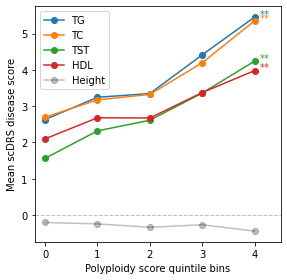

In [13]:
# Ploidy results for FACs GWAS traits
trait_list = ['UKB_460K.biochemistry_Testosterone_Male',
              'UKB_460K.biochemistry_Triglycerides',
              'UKB_460K.biochemistry_HDLcholesterol', 
              'UKB_460K.biochemistry_Cholesterol',
              'UKB_460K.body_HEIGHTz'
             ]
df_plot = dic_cov['facs'][['ploidy']].copy()
df_plot = df_plot.join(dic_score['facs'][['%s.norm_score'%x for x in trait_list]])
df_plot['bin'] = pd.qcut(df_plot['ploidy'], q=5, labels=False)

# Reorder traits 
cell_list = df_plot.index[df_plot['ploidy']>np.quantile(df_plot['ploidy'], 0.8)]
temp_df = pd.DataFrame(index=trait_list,
                       data={'score': [dic_score['facs'].loc[cell_list, '%s.norm_score'%x].mean()
                                       for x in trait_list]})
temp_df.sort_values(by='score', ascending=False, inplace=True)
trait_list = list(temp_df.index)

i_color = 0
y_text = 8
plt.figure(figsize=[4.1,4])
for i_trait,trait in enumerate(trait_list):
    alpha_=0.25 if trait=='UKB_460K.body_HEIGHTz' else 1
    color_='k' if trait=='UKB_460K.body_HEIGHTz' else 'C%d'%i_color
    temp_df = df_plot.groupby('bin').agg({'%s.norm_score'%trait: np.mean})
    temp_df.columns = ['mean']
    plt.plot(temp_df.index, temp_df['mean'], 'o-', label=DF_TRAIT_INFO.loc[trait, 'Code'], 
             color=color_, alpha=alpha_)
    y_text = min(y_text-0.1, temp_df['mean'][4])
    plt.text(4.1, y_text, dic_stats['facs.reg_joint'].loc[trait,'P_STR.ploidy'], color='C%d'%i_color)
    i_color += 1
    
plt.axhline(y=0, ls="--", color="k", lw=1, alpha=0.25)
plt.xlim([-0.2,4.5])
plt.legend()
plt.xlabel('Polyploidy score quintile bins')
plt.ylabel('Mean scDRS disease score')
plt.tight_layout()
# plt.savefig(FIG_PATH+'/hepreg.ploidy.facs.svg')
plt.show()